In [1]:
%matplotlib inline

In [2]:
import glob, os, sys
import xarray
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
fs=14
plt.rc("font",size=fs)

In [3]:
import numpy.matlib

In [4]:
from IPython.display import Image

In [5]:
from matplotlib.ticker import FormatStrFormatter

In [6]:
# from scipy.signal import welch

In [7]:
inpath = "/glade/scratch/doubrawa/post_processing/"

In [8]:
days = [20,21,28,29,30]

### which times we are keeping? i.e. which ones are convective cell cases

In [9]:
convective      = pd.read_csv(os.path.join(inpath,"datetimes_ziL_gt_25.csv"),header=None,index_col=[0])
convective_list = np.array([ pd.Timestamp(l[0]) for l in convective.values.tolist() ])

In [10]:
nt = len(convective_list)

In [11]:
nt

269

### what is our zi?

In [12]:
extent_of_interest_km = 15
zi_dict = {}
for day in days:
    infile = "PBLH_SPATIAL_AVG_{0:.0f}km_by_{0:.0f}km_D02_March{1}.csv".format(extent_of_interest_km,day)
    zi_dict[day] = pd.read_csv(os.path.join(inpath,infile), index_col=0, parse_dates=True)

### define some parameters for automated plotting

In [13]:
labels = {"ws":"Horizontal Wind Speed [m/s]",
          "ws_filt":"Horizontal Wind Speed [m/s]",
          "theta_filt":"Potential Temperature [K]",
          "tke":"Turbulent Kinetic Energy [m$^2$ s$^{{-2}}$]",
          "tke_filt":"Turbulent Kinetic Energy [m$^2$ s$^{{-2}}$]",
          "wT":"Kinematic Heat Flux [m s$^{{-1}}$ K]",
          "wT_filt":"Kinematic Heat Flux [m s$^{{-1}}$ K]",
          "w_filt":"Vertical velocity [m/s]"}

xlims = {"ws":[0,5],
         "ws_filt":[0,5],
         "theta_filt":[300,310],
         "tke":[0,4],
         "tke_filt":[0,4],
         "wT":[],
         "wT_filt":[]}

In [14]:
colors = { "LES":"k",
          "vles":"#808B96",
          "mynn":"#641E16",
           "ysu":"#A93226",
            "sh":"#D98880",}

lss    = { "LES":"-",
          "vles":"-",
          "mynn":"-.",
           "ysu":"--",
            "sh":":",}

## funcs

In [15]:
def return_hamming(Nx,Ny):

    # combo of uniform window in the middle and hamming window on edges:
    npts_buffer = 16

    # create a 1-d hamming window : hamm_1d.shape = (100,)
    hamm_1d     = np.hamming(npts_buffer*2)
    # repeat it : B.shape = (100, 100)
    B           = np.matlib.repmat(hamm_1d,npts_buffer*2,1)
    # transpose it : C.shape = (100,100)
    C           = np.transpose(B)
    # now get the two-dimensional hamming window : hamm_2d_s.shape = (100,100)
    hamm_2d_s   = B*C

    # allocate space for the final 2d-filter
    hamm_2d = np.zeros([Ny,Nx])

    # fill it with ones (no filter) anywhere that the window won't be applied (inside the domain, anywhere inside the buffer)        
    for ii in range(0+npts_buffer,Nx-npts_buffer):
        for jj in range(0+npts_buffer,Ny-npts_buffer):
            hamm_2d[jj,ii] = 1.0

    # now put the filter values in there

    # south west corner
    hamm_2d[0:npts_buffer,0:npts_buffer] = hamm_2d_s[0:npts_buffer,0:npts_buffer]

    # south east corner
    hamm_2d[0:npts_buffer,Nx-npts_buffer:Nx] = hamm_2d_s[0:npts_buffer,2*npts_buffer-npts_buffer:2*npts_buffer]

    # north west corner
    hamm_2d[Ny-npts_buffer:Ny,0:npts_buffer] = hamm_2d_s[2*npts_buffer-npts_buffer:2*npts_buffer,0:npts_buffer]

    # north east corner
    hamm_2d[Ny-npts_buffer:Ny,Nx-npts_buffer:Nx] = hamm_2d_s[2*npts_buffer-npts_buffer:2*npts_buffer,2*npts_buffer-npts_buffer:2*npts_buffer]

    # south boundary
    hann_tmp = hamm_1d[0:npts_buffer]
    len_tmp  = Nx-2*npts_buffer
    hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
    hann_tmp = np.transpose(hann_tmp)
    hamm_2d[0:npts_buffer,npts_buffer:Nx-npts_buffer] = hann_tmp

    # north boundary
    hann_tmp = hamm_1d[npts_buffer:2*npts_buffer]
    len_tmp  = Nx-2*npts_buffer
    hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
    hann_tmp = np.transpose(hann_tmp)
    hamm_2d[Ny-npts_buffer:Ny,npts_buffer:Nx-npts_buffer] = hann_tmp

    # west boundary
    hann_tmp = hamm_1d[0:npts_buffer]
    len_tmp  = Ny-2*npts_buffer
    hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
    hamm_2d[npts_buffer:Ny-npts_buffer,0:npts_buffer] = hann_tmp

    # east boundary
    hann_tmp = hamm_1d[npts_buffer:2*npts_buffer]
    len_tmp  = Ny-2*npts_buffer
    hann_tmp = np.matlib.repmat(hann_tmp,len_tmp,1)
    hamm_2d[npts_buffer:Ny-npts_buffer,Nx-npts_buffer:Nx] = hann_tmp
    
    return hamm_2d

### i/o

In [16]:
sims = ["LES","vles","mynn","ysu","sh"]

In [17]:
varnames = ["ws_filt","theta_filt","w_filt","tke_filt","wT_filt"]

In [18]:
nk = 10
nj = 90
ni = 90
nt = len(convective_list)

T_prime_4d  = {sim:np.zeros((nk,nj,ni,nt)) for sim in sims}
ws_prime_4d = {sim:np.zeros((nk,nj,ni,nt)) for sim in sims}
w_prime_4d  = {sim:np.zeros((nk,nj,ni,nt)) for sim in sims}

In [19]:
T_prime_4d["LES"] = np.zeros((nk,1200,1200,nt))
ws_prime_4d["LES"] = np.zeros((nk,1200,1200,nt))
w_prime_4d["LES"] = np.zeros((nk,1200,1200,nt))

In [ ]:
all_data = {}

for sim in sims[0:1]:
    print(sim)
    count = 0
    for datetime in convective_list:
        
        # open file for this simulation and this time
        sys.stdout.write('\r{0}'.format(datetime))            
        filepath = glob.glob(os.path.join(inpath,"*_{0}_*{1:%Y-%m-%d_%H:%M}*plus_filtered.nc".format(sim,datetime)))[0]        
        all_data[sim] = xarray.open_dataset(filepath)
        all_data[sim] = all_data[sim].isel(bottom_top=np.arange(0,nk,1))

        
        # compute wind speed
        all_data[sim]["ws_filt"] = np.sqrt(all_data[sim]["u_filt"]**2 + all_data[sim]["v_filt"]**2)     
        
        # compute horizontal averages of each quantity
        ws_mean  = np.mean(all_data[sim]["ws_filt"].values,axis=(1,2))
        w_mean   = np.mean(all_data[sim]["w_filt"].values,axis=(1,2))
        T_mean   = np.mean(all_data[sim]["theta_filt"].values,axis=(1,2))
        
        # remove horizontal averages to get primes
        ws_prime = all_data[sim]["ws_filt"].values - ws_mean[:,np.newaxis,np.newaxis]
        w_prime  = all_data[sim]["w_filt"].values - w_mean[:,np.newaxis,np.newaxis]
        T_prime  = all_data[sim]["theta_filt"].values - T_mean[:,np.newaxis,np.newaxis]
        
        ws_prime_4d[sim][...,count] = ws_prime.copy()
        w_prime_4d[sim][...,count]  = w_prime.copy()
        T_prime_4d[sim][...,count]  = T_prime.copy()        
        
        count += 1
    print('\r')

LES
2015-03-20 14:00:00

# junkyard

In [38]:
T_prime_4d[sim].shape

(41, 90, 90, 269)

In [56]:
k = 6

psd_2d = {sim:np.zeros((nj,ni,nt)) for sim in sims}

for sim in sims:
    for it in range(nt):
        sys.stdout.write('\r{0}'.format(it))    

        # 1. get 2-d arrays of perturbations
        tmp = w_prime_4d[sim][k,...,it]
        (npts,npts) = tmp.shape

        # 3. apply window (to minimize noise since the arrays are not periodic in space)
        hamm_2d = return_hamming(Nx=npts,Ny=npts)    
        tmp = tmp * hamm_2d

        # 4. apply fft
        tmp_psd_2d          = fftpack.fft2(tmp)

        # 5. save it
        psd_2d[sim][...,it] = tmp_psd_2d.copy()

185

/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/glade/u/home/doubrawa/anaconda2/envs/wrfenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


268

In [57]:
psd_2d_timeavg = {}
psd_2d_timeavg_shift = {}

for sim in sims:
    psd_2d_timeavg[sim] = np.nanmean(psd_2d[sim],axis=2)#psd_2d[...,10]#

    # 5. shift it so we can visualize it better
    psd_2d_timeavg_shift[sim] = fftpack.fftshift(psd_2d_timeavg[sim])

In [58]:
# 6. get wavenums
d = 25.0 if sim=="LES" else 333.3333
fr = fftpack.fftfreq(npts, d=d)
fr = np.sort(fr)

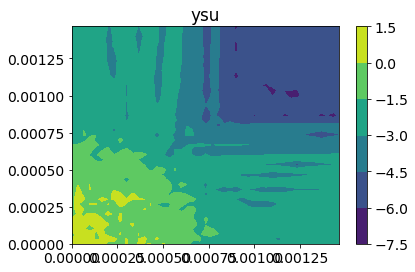

In [61]:
sim = 'ysu'

fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_title(sim)

# indices to keep
idx = list(np.where((fr>=0)&(fr<=np.max(fr)))[0])
idx0 = idx[0]
idx1 = idx[-1]

fr_start = np.argmin(np.abs(fr))

#p = ax.contourf(fr[idx],fr[idx], \
#                np.log10(np.abs(psd_2d_timeavg_shift[idx0:idx1+1,idx0:idx1+1])))

psd_plot = np.log10(np.abs(psd_2d_timeavg_shift[sim]))

p = ax.contourf(fr[fr_start:],fr[fr_start:], psd_plot[fr_start:,fr_start:])


plt.colorbar(p)

# lim = 1/666.
# ax.set_xlim([-lim,lim])
# ax.set_ylim([-lim,lim])  

# tickmarks = [-300, -100, 100, 300]
# ax.set_xticks([1/a for a in tickmarks])
# ax.set_xticklabels(["{0}\n{1}".format(q,1/q) for q in np.arange(-0.004,0.0041,0.002)])    


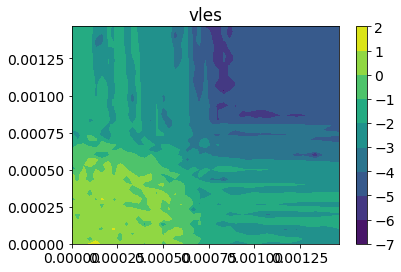

In [31]:
fig = plt.figure()
ax  = fig.add_subplot(111)
ax.set_title(sim)

# indices to keep
idx = list(np.where((fr>=0)&(fr<=np.max(fr)))[0])
idx0 = idx[0]
idx1 = idx[-1]

fr_start = np.argmin(np.abs(fr))

#p = ax.contourf(fr[idx],fr[idx], \
#                np.log10(np.abs(psd_2d_timeavg_shift[idx0:idx1+1,idx0:idx1+1])))

psd_plot = np.log10(np.abs(psd_2d_timeavg_shift))

p = ax.contourf(fr[fr_start:],fr[fr_start:], psd_plot[fr_start:,fr_start:])


plt.colorbar(p)

# lim = 1/666.
# ax.set_xlim([-lim,lim])
# ax.set_ylim([-lim,lim])  

# tickmarks = [-300, -100, 100, 300]
# ax.set_xticks([1/a for a in tickmarks])
# ax.set_xticklabels(["{0}\n{1}".format(q,1/q) for q in np.arange(-0.004,0.0041,0.002)])    


In [40]:
ifreq_zero = np.argmin(np.abs(fr))

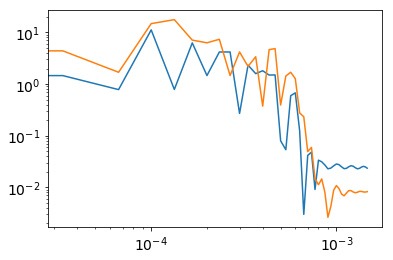

In [44]:
plt.loglog(fr[ifreq_zero:], np.abs(psd_2d_timeavg_shift)[ifreq_zero:,ifreq_zero])
plt.loglog(fr[ifreq_zero:], np.abs(psd_2d_timeavg_shift)[ifreq_zero,ifreq_zero:])

In [93]:
1/50.

0.02

In [86]:
fr[idx]

array([0.00000000e+00, 3.33333367e-05, 6.66666733e-05, 1.00000010e-04,
       1.33333347e-04, 1.66666683e-04, 2.00000020e-04, 2.33333357e-04,
       2.66666693e-04, 3.00000030e-04, 3.33333367e-04, 3.66666703e-04,
       4.00000040e-04, 4.33333377e-04, 4.66666713e-04, 5.00000050e-04,
       5.33333387e-04, 5.66666723e-04, 6.00000060e-04, 6.33333397e-04,
       6.66666733e-04, 7.00000070e-04, 7.33333407e-04, 7.66666743e-04,
       8.00000080e-04, 8.33333417e-04, 8.66666753e-04, 9.00000090e-04,
       9.33333427e-04, 9.66666763e-04, 1.00000010e-03, 1.03333344e-03,
       1.06666677e-03, 1.10000011e-03, 1.13333345e-03, 1.16666678e-03,
       1.20000012e-03, 1.23333346e-03, 1.26666679e-03, 1.30000013e-03,
       1.33333347e-03, 1.36666680e-03, 1.40000014e-03, 1.43333348e-03,
       1.46666681e-03])

In [51]:
fr

array([-1.50000015e-03, -1.46666681e-03, -1.43333348e-03, -1.40000014e-03,
       -1.36666680e-03, -1.33333347e-03, -1.30000013e-03, -1.26666679e-03,
       -1.23333346e-03, -1.20000012e-03, -1.16666678e-03, -1.13333345e-03,
       -1.10000011e-03, -1.06666677e-03, -1.03333344e-03, -1.00000010e-03,
       -9.66666763e-04, -9.33333427e-04, -9.00000090e-04, -8.66666753e-04,
       -8.33333417e-04, -8.00000080e-04, -7.66666743e-04, -7.33333407e-04,
       -7.00000070e-04, -6.66666733e-04, -6.33333397e-04, -6.00000060e-04,
       -5.66666723e-04, -5.33333387e-04, -5.00000050e-04, -4.66666713e-04,
       -4.33333377e-04, -4.00000040e-04, -3.66666703e-04, -3.33333367e-04,
       -3.00000030e-04, -2.66666693e-04, -2.33333357e-04, -2.00000020e-04,
       -1.66666683e-04, -1.33333347e-04, -1.00000010e-04, -6.66666733e-05,
       -3.33333367e-05,  0.00000000e+00,  3.33333367e-05,  6.66666733e-05,
        1.00000010e-04,  1.33333347e-04,  1.66666683e-04,  2.00000020e-04,
        2.33333357e-04,  

In [48]:
1/30000.

3.3333333333333335e-05

# play with 1d spectra

In [19]:
#         d = 25.0 if sim=="LES" else 333.3333333   
#         tmp_1d = tmp[isn,:]
#         fr,psd_1d = welch(tmp_1d, fs=1/d)


In [20]:
unit="m/s"

Text(0, 0.5, 'Energy Spectral Density [(m/s)$^2$ m]')

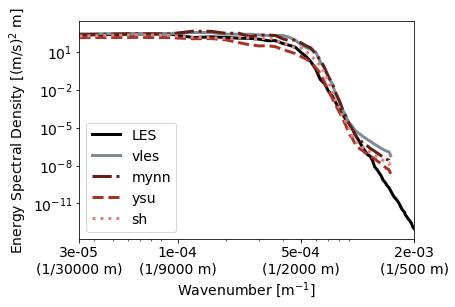

In [232]:
k = 8

fig = plt.figure()
ax  = fig.add_subplot(111)

for sim in all_data.keys():
    
    # 1. get 2-d arrays
    tmp = all_data[sim]["w_filt"].isel(bottom_top=k).values
    tmp2 = all_data[sim]["ws"].isel(bottom_top=k).values    

    # 2. remove spatial mean
    tmp_mean = np.mean(tmp)                
    tmp = tmp - tmp_mean
    (npts,npts) = tmp.shape

    tmp2_mean = np.mean(tmp2)                
    tmp2 = tmp2 - tmp2_mean
    (npts,npts) = tmp2.shape
    
    
    # 4. apply fft
    for isn in range(npts):
        d = 25.0 if sim=="LES" else 333.3333333   
        seg_length = 30000 #meters
        seg_npts   = seg_length/d
        
        tmp_1d = tmp[isn,:]
        fr,psd_1d = welch(tmp_1d, fs=1/d, nperseg=seg_npts)
        
        tmp_1d2 = tmp2[isn,:]
        fr2,psd_1d2 = welch(tmp_1d2, fs=1/d, nperseg=seg_npts)        
        
        if isn==0:
            psd = psd_1d.copy()
            psd2 = psd_1d2.copy()            
        else:
            psd = psd+psd_1d.copy()
            psd2 = psd2+psd_1d2.copy()            
    psd /= isn+1
    psd2 /= isn+1    
    
#     print("***********")
#     print(sim)
#     print(npts)
#     print(d)
#     print(1/np.max(fr))
#     print(1/np.min(fr[1:]))  
#     print("actual variance       {0:.7f}".format(np.var(tmp_1d)))
#     spectrumwide_integration = np.trapz(psd,fr)
#     print("spectrumwide integral {0:.7f}".format(spectrumwide_integration))    
#     idx2 = (np.round(1/fr) >= 1000.)
#     integration = np.trapz(psd[idx2],fr[idx2])
#     print("low wavenums integral {0:.7f}".format(integration))
    
    idx = (fr>=(1/seg_length))&(fr<=2e-3)
    p = ax.loglog(fr[idx],psd[idx],label=sim,color=colors[sim],ls=lss[sim],lw=3)
#     p = ax.loglog(fr2[idx],psd2[idx],label=sim,ls='--',color=colors[sim])    

plt.legend(loc='best')   
ax.set_xlim([1/seg_length,2e-3])

xticks = np.asarray([30000,9000, 2000, 500])
ax.set_xticks(1/xticks)
ax.set_xticklabels(["{0:.0e}\n(1/{1} m)".format(1/q,q) for q in xticks])    
    
ax.set_xlabel("Wavenumber [m$^{-1}$]")
ax.set_ylabel("Energy Spectral Density [({0})$^2$ m]".format(unit))

Text(0, 0.5, 'Energy Spectral Density [(m/s)$^2$ m]')

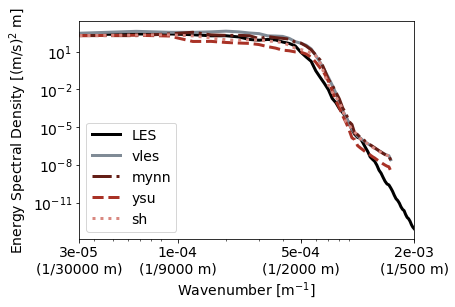

In [328]:
fig = plt.figure()
ax  = fig.add_subplot(111)

for sim in all_data.keys():
    
    # 1. get 2-d arrays
    tmp = all_data[sim]["w_filt"].isel(bottom_top=k).values
    tmp2 = all_data[sim]["ws"].isel(bottom_top=k).values    

    # 2. remove spatial mean
    tmp_mean = np.mean(tmp)                
    tmp = tmp - tmp_mean
    (npts,npts) = tmp.shape

    tmp2_mean = np.mean(tmp2)                
    tmp2 = tmp2 - tmp2_mean
    (npts,npts) = tmp2.shape
    
    
    # 4. apply fft
    for isn in range(npts):
        d = 25.0 if sim=="LES" else 333.3333333   
        seg_length = 30000 #meters
        seg_npts   = seg_length/d
        
        tmp_1d = tmp[:,isn]
        fr,psd_1d = welch(tmp_1d, fs=1/d, nperseg=seg_npts)
        
        tmp_1d2 = tmp2[:,isn]
        fr2,psd_1d2 = welch(tmp_1d2, fs=1/d, nperseg=seg_npts)        
        
        if isn==0:
            psd = psd_1d.copy()
            psd2 = psd_1d2.copy()            
        else:
            psd = psd+psd_1d.copy()
            psd2 = psd2+psd_1d2.copy()            
    psd /= isn+1
    psd2 /= isn+1    
    
#     print("***********")
#     print(sim)
#     print(npts)
#     print(d)
#     print(1/np.max(fr))
#     print(1/np.min(fr[1:]))  
#     print("actual variance       {0:.7f}".format(np.var(tmp_1d)))
#     spectrumwide_integration = np.trapz(psd,fr)
#     print("spectrumwide integral {0:.7f}".format(spectrumwide_integration))    
#     idx2 = (np.round(1/fr) >= 1000.)
#     integration = np.trapz(psd[idx2],fr[idx2])
#     print("low wavenums integral {0:.7f}".format(integration))
    
    idx = (fr>=(1/seg_length))&(fr<=2e-3)
    p = ax.loglog(fr[idx],psd[idx],label=sim,color=colors[sim],ls=lss[sim],lw=3)
#     p = ax.loglog(fr2[idx],psd2[idx],label=sim,ls='--',color=colors[sim])    

plt.legend(loc='best')   
ax.set_xlim([1/seg_length,2e-3])

xticks = np.asarray([30000,9000, 2000, 500])
ax.set_xticks(1/xticks)
ax.set_xticklabels(["{0:.0e}\n(1/{1} m)".format(1/q,q) for q in xticks])    
    
ax.set_xlabel("Wavenumber [m$^{-1}$]")
ax.set_ylabel("Energy Spectral Density [({0})$^2$ m]".format(unit))

Text(0, 0.5, 'Energy Spectral Density [(m/s)$^2$ m]')

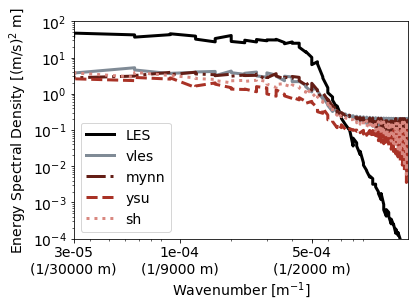

In [329]:
fig = plt.figure()
ax  = fig.add_subplot(111)

for sim in all_data.keys():
    
    # 1. get 2-d arrays
    tmp = all_data[sim]["w_filt"].isel(bottom_top=k).values
    tmp2 = all_data[sim]["ws"].isel(bottom_top=k).values    

    # 2. remove spatial mean
    tmp_mean = np.mean(tmp)                
    tmp = tmp - tmp_mean
    (npts,npts) = tmp.shape
       
    # 4. apply fft
    for isn in range(npts):
        d = 25.0 if sim=="LES" else 333.3333333   
        tmp_1d = tmp[:,isn]

        psd_1d = fftpack.rfft(tmp_1d)
        fr = fftpack.rfftfreq(len(tmp_1d),d=d)
        
        if isn==0:
            psd = np.abs(psd_1d).copy()
        else:
            psd = psd+np.abs(psd_1d).copy()
    psd /= isn+1

    p   = ax.loglog(fr,psd,label=sim,color=colors[sim],ls=lss[sim],lw=3)
#     p = ax.loglog(fr2[idx],psd2[idx],label=sim,ls='--',color=colors[sim])    

plt.legend(loc='best')   


xticks = np.asarray([30000,9000, 2000, 500])
ax.set_xticks(1/xticks)
ax.set_xticklabels(["{0:.0e}\n(1/{1} m)".format(1/q,q) for q in xticks])    
    
ax.set_ylim([1e-4,1e2])    
ax.set_xlim([1/seg_length,1/666.])

ax.set_xlabel("Wavenumber [m$^{-1}$]")
ax.set_ylabel("Energy Spectral Density [({0})$^2$ m]".format(unit))

# play with 2d spectra

In [46]:
from wrf import to_np

In [87]:
from matplotlib import ticker

In [234]:
tmp_rles = to_np(all_data["LES"]["ws_filt"].isel(bottom_top=k))
tmp_ysu  = to_np(all_data["ysu"]["ws_filt"].isel(bottom_top=k))

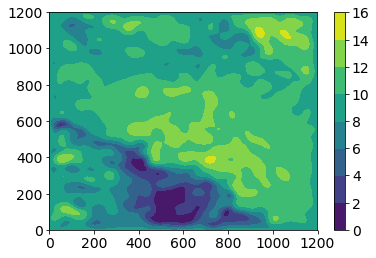

In [235]:
plt.contourf(tmp_rles)
plt.colorbar()

In [148]:
psd_rles = fftpack.fft2(tmp_rles-np.mean(tmp_rles), overwrite_x=False)
psd_rles = fftpack.fftshift(psd_rles) #Shift the zero-frequency component to the center of the spectrum.
freq_rles = fftpack.fftfreq(len(tmp_rles),d=25.0)
freq_rles = np.sort(freq_rles)

psd_ysu = fftpack.fft2(tmp_ysu-np.mean(tmp_ysu), overwrite_x=False)
psd_ysu = fftpack.fftshift(psd_ysu) #Shift the zero-frequency component to the center of the spectrum.
freq_ysu = fftpack.fftfreq(len(tmp_ysu),d=25.0)
freq_ysu = np.sort(freq_ysu)

In [140]:
from scipy import interpolate

In [240]:
from matplotlib.lines import Line2D

In [297]:
zmean = float(all_data["LES"].z.isel(bottom_top=k).mean().values)

[Text(0, 0, '$\\frac{1}{2\\Delta_{{GZ}}}$'),
 Text(0, 0, '$\\frac{1}{1,000}$'),
 Text(0, 0, '$\\frac{1}{5,000}$'),
 Text(0, 0, '$-\\frac{1}{5,000}$'),
 Text(0, 0, '$-\\frac{1}{1,000}$'),
 Text(0, 0, '$-\\frac{1}{2\\Delta_{{GZ}}}$')]

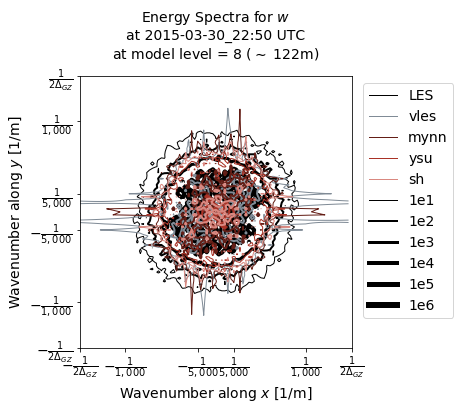

In [333]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,1,1,aspect="equal")

    
for sim in all_data.keys():
    
    tmp = to_np(all_data[sim]["w_filt"].isel(bottom_top=k))
    tmp = tmp-np.mean(tmp)

#     # 3. apply window (to minimize noise since the arrays are not periodic in space)
#     hamm_2d = return_hamming(Nx=len(tmp),Ny=len(tmp))    
#     tmp = tmp * hamm_2d    
    
    psd = fftpack.fft2(tmp-np.mean(tmp), overwrite_x=False)
    psd = fftpack.fftshift(psd) #Shift the zero-frequency component to the center of the spectrum.

    d = 25.0 if sim=="LES" else 333.33333
    freq = fftpack.fftfreq(len(tmp),d=d)
    freq = np.sort(freq)
    
#     if 1:#sim=="LES":
#         f = interpolate.interp2d(freq, freq, psd, kind='cubic')
#         psd = f(freq_ysu,freq_ysu)
#         freq = freq_ysu


    #p = ax.contourf(freq, freq, np.abs(psd), locator=ticker.LogLocator(), levels=[1e0,1e1,1e2,1e3,1e4,1e5,1e6])
    #plt.colorbar(p)
    ax.contour(freq, freq, np.abs(psd), locator=ticker.LogLocator(), 
               levels=[1e1,1e2,1e3,1e4,1e5,1e6], colors=colors[sim],
              linewidths=[1,2,3,4,5,6])

lim = -1/666.
ax.set_xlim([lim,-lim])
ax.set_ylim([lim,-lim])

ax.set_title("Energy Spectra for $w$\nat {0} UTC\nat model level = {1} ($\sim$ {2:.0f}m)".format(all_data[sim].valid,k,zmean),
             fontsize=fs, y=1.05)

ax.set_xlabel("Wavenumber along $x$ [1/m]")
ax.set_ylabel("Wavenumber along $y$ [1/m]")

lines  = []
labels = []

for sim in sims:
    lines.append(Line2D([0], [0], color=colors[sim], linewidth=1, marker='None', ms=8, mec='k',mew=1))
    labels.append(sim)

for expp in [1,2,3,4,5,6]:
    lines.append(Line2D([0], [0], color='k', linewidth=expp, marker='None', ms=8, mec='k',mew=1))
    labels.append("1e{0}".format(expp))
    
    
plt.legend(lines,labels,bbox_to_anchor=(1.4,1))    

xticks = [1/(2*333.), 
          1/(1000.), 
          1/(5000.),
          -1/5000.,
         -1/1000.,
         -1/666.]
xlabs  = [r"$\frac{1}{2\Delta_{{GZ}}}$",
          r"$\frac{1}{1,000}$",          
          r"$\frac{1}{5,000}$",
         r"$-\frac{1}{5,000}$",
          r"$-\frac{1}{1,000}$",r"$-\frac{1}{2\Delta_{{GZ}}}$"          ]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)

ax.set_yticks(xticks)
ax.set_yticklabels(xlabs)

[Text(0, 0, '0'),
 Text(0, 0, '4$\\Delta_{{GZ}}$'),
 Text(0, 0, '2$\\Delta_{{GZ}}$')]

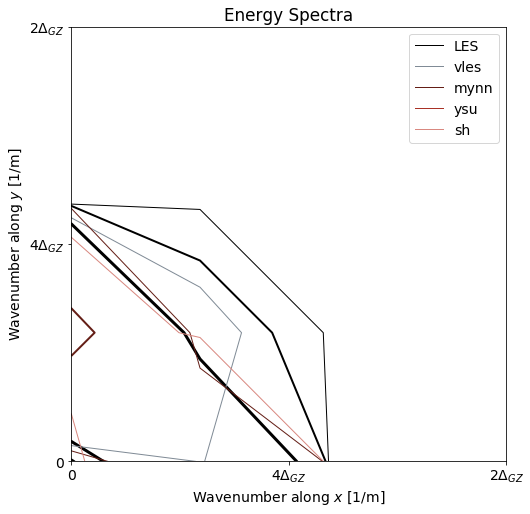

In [264]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(1,1,1,aspect="equal")

    
for sim in all_data.keys():
    
    tmp = to_np(all_data[sim]["w_filt"].isel(bottom_top=k))

    psd = fftpack.fft2(tmp-np.mean(tmp), overwrite_x=False)
    psd = fftpack.fftshift(psd) #Shift the zero-frequency component to the center of the spectrum.

    d = 25.0 if sim=="LES" else 333.0
    freq = fftpack.fftfreq(len(tmp),d=d)
    freq = np.sort(freq)
    
    if 1:#sim=="LES":
        f = interpolate.interp2d(freq, freq, psd, kind='cubic')
        psd = f(freq_ysu,freq_ysu)
        freq = freq_ysu


    #p = ax.contourf(freq, freq, np.abs(psd), locator=ticker.LogLocator(), levels=[1e0,1e1,1e2,1e3,1e4,1e5,1e6])
    #plt.colorbar(p)
    ax.contour(freq, freq, np.abs(psd), locator=ticker.LogLocator(), 
               levels=[1e1,1e2,1e3,1e4,1e5,1e6], colors=colors[sim],
              linewidths=[1,2,3,4,5,6])

lim = 1/666.
ax.set_xlim([0,lim])
ax.set_ylim([0,lim])

ax.set_title("Energy Spectra")

ax.set_xlabel("Wavenumber along $x$ [1/m]")
ax.set_ylabel("Wavenumber along $y$ [1/m]")

lines  = []
labels = []

for sim in sims:
    lines.append(Line2D([0], [0], color=colors[sim], linewidth=1, marker='None', ms=8, mec='k',mew=1))
    labels.append(sim)
    
plt.legend(lines,labels)    

xticks = [0,1/(2*666.),1/666]
xlabs  = ["0","4$\Delta_{{GZ}}$","2$\Delta_{{GZ}}$"]
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs)

ax.set_yticks(xticks)
ax.set_yticklabels(xlabs)

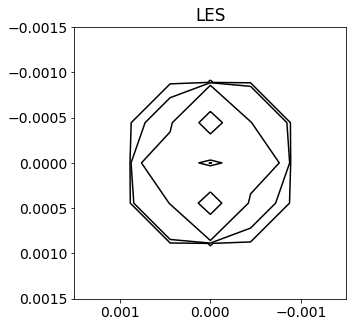

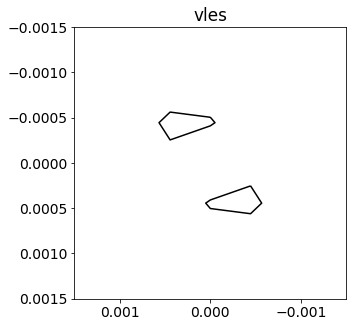

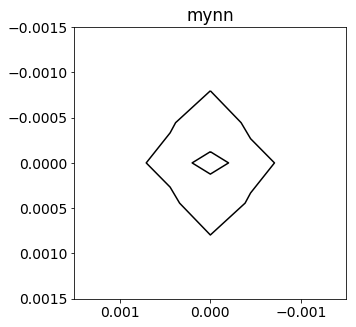

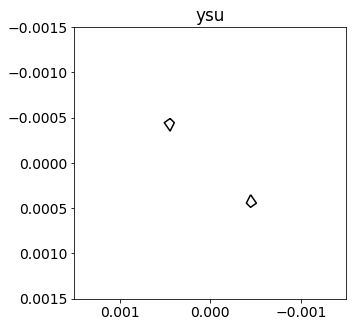

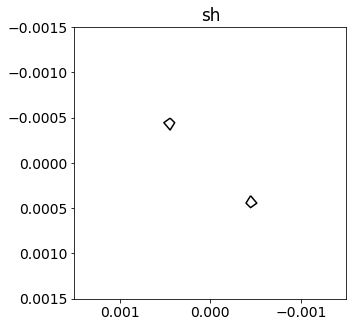

In [214]:
for sim in all_data.keys():
    
    tmp = to_np(all_data[sim]["w_filt"].isel(bottom_top=k))

    psd = fftpack.fft2(tmp-np.mean(tmp), overwrite_x=False)
    psd = fftpack.fftshift(psd) #Shift the zero-frequency component to the center of the spectrum.

    d = 25.0 if sim=="LES" else 333.0
    freq = fftpack.fftfreq(len(tmp),d=d)
    freq = np.sort(freq)
    
    if 1:#sim=="LES":
        f = interpolate.interp2d(freq, freq, psd, kind='cubic')
        psd = f(freq_ysu,freq_ysu)
        freq = freq_ysu

    fig = plt.figure(figsize=(15,5))

    ax = fig.add_subplot(1,1,1,aspect="equal")

    #p = ax.contourf(freq, freq, np.abs(psd), locator=ticker.LogLocator(), levels=[1e0,1e1,1e2,1e3,1e4,1e5,1e6])
    #plt.colorbar(p)
    ax.contour(freq, freq, np.abs(psd), locator=ticker.LogLocator(), levels=[1e0,1e1,1e2,1e3,1e4,1e5,1e6], colors='k')

    lim = -1/666.
    ax.set_xlim([-lim,lim])
    ax.set_ylim([-lim,lim])

    ax.set_title(sim)
    

# ax.set_xticks(np.arange(-0.004,0.0041,0.002))
# ax.set_xticklabels(["{0}\n{1}".format(q,1/q) for q in np.arange(-0.004,0.0041,0.002)])

(0.0015015015015015015, -0.0015015015015015015)

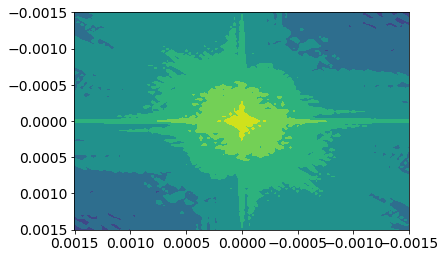

In [191]:
plt.contourf(freq, freq, np.abs(psd), locator=ticker.LogLocator(), levels=[1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6])
lim = -1/666.
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

In [194]:
f = interpolate.interp2d(freq, freq, psd, kind='cubic')
fwant = fftpack.fftfreq(90,d=333.)

In [199]:
psd2 = f(freq_ysu,freq_ysu)

(0.0015015015015015015, -0.0015015015015015015)

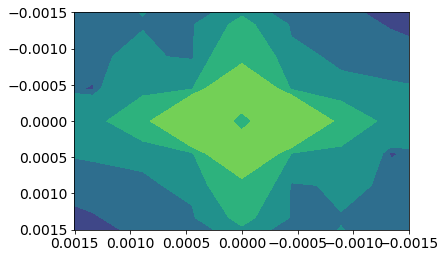

In [200]:
plt.contourf(freq_ysu, freq_ysu, np.abs(psd2), locator=ticker.LogLocator(), levels=[1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6])
lim = -1/666.
plt.xlim([-lim,lim])
plt.ylim([-lim,lim])

# junk

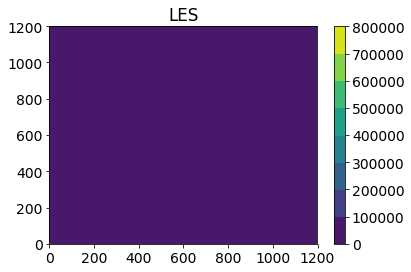

In [34]:
for sim in all_data.keys():
    
    # 1. get 2-d arrays
    tmp = all_data[sim]["ws_filt"].isel(bottom_top=k)

    # 2. remove spatial mean
    tmp_mean = np.mean(tmp)                
    tmp = tmp - tmp_mean
    (npts,npts) = tmp.shape

    # 3. apply window (to minimize noise since the arrays are not periodic in space)
    hamm_2d = return_hamming(Nx=npts,Ny=npts)    
    tmp = tmp * hamm_2d

    # 4. apply fft
    tmp_psd_2d          = fftpack.fft2(tmp)

#     # 5. shift it so we can visualize it better
#     tmp_psd_2d = fftpack.fftshift(tmp_psd_2d)
    
    # 6. get wavenums
    d = 25.0 if sim=="LES" else 333.3333
    fr = fftpack.fftfreq(npts, d=d)
    fr = np.sort(fr)

    fig = plt.figure()
    ax  = fig.add_subplot(111)
    ax.set_title(sim)
    p = ax.contourf(np.abs(tmp_psd_2d))#,levels=np.arange(0,1000.01,10))
    plt.colorbar(p)
#     ax.set_xticks(np.arange(-0.004,0.0041,0.002))
#     ax.set_xticklabels(["{0}\n{1}".format(q,1/q) for q in np.arange(-0.004,0.0041,0.002)])    
    
#     lim = -0.002
#     ax.set_xlim([0,10])
#     ax.set_ylim([0,10])  
    
    break

In [ ]:
for isn in range(nwe):

In [ ]:
fig = plt.figure()
ax  = fig.add_subplot(111)



In [ ]:
all_data = {}

for datetime in convective_list:
  
    print(datetime)
    
    for sim in sims:
        
        filepath = glob.glob(os.path.join(inpath,"*_{0}_*{1:%Y-%m-%d_%H:%M}*plus_filtered.nc".format(sim,datetime)))[0]
        print(filepath)
        
        all_data[sim] = xarray.open_dataset(filepath)
        
        all_data[sim]["ws"] = np.sqrt(all_data[sim]["u"]**2 + all_data[sim]["v"]**2)
        all_data[sim]["wd"] = 270.0 - np.degrees(np.arctan2(all_data[sim]["v"],all_data[sim]["u"]))

        all_data[sim]["ws_filt"] = np.sqrt(all_data[sim]["u_filt"]**2 + all_data[sim]["v_filt"]**2)
        all_data[sim]["wd_filt"] = 270.0 - np.degrees(np.arctan2(all_data[sim]["v_filt"],all_data[sim]["u_filt"]))            
                
        u_mean = all_data[sim]["u_filt"].mean(dim=["south_north","west_east"])
        v_mean = all_data[sim]["v_filt"].mean(dim=["south_north","west_east"])
        w_mean = all_data[sim]["w_filt"].mean(dim=["south_north","west_east"])
        T_mean = all_data[sim]["theta_filt"].mean(dim=["south_north","west_east"])

        u_prime = all_data[sim]["u_filt"] - u_mean
        v_prime = all_data[sim]["v_filt"] - v_mean
        w_prime = all_data[sim]["w_filt"] - w_mean
        T_prime = all_data[sim]["theta_filt"] - T_mean

        u_prime_u_prime_mean = (u_prime**2).mean(dim=["south_north","west_east"])
        v_prime_v_prime_mean = (v_prime**2).mean(dim=["south_north","west_east"])
        w_prime_w_prime_mean = (w_prime**2).mean(dim=["south_north","west_east"])
        w_prime_T_prime_mean = (w_prime*T_prime).mean(dim=["south_north","west_east"])

        tke = 0.5 * (u_prime_u_prime_mean + v_prime_v_prime_mean + w_prime_w_prime_mean)

        all_data[sim]["tke_filt"] = tke.copy()
        all_data[sim]["wT_filt"]  = w_prime_T_prime_mean.copy()  
        
        u_mean = all_data[sim]["u"].mean(dim=["south_north","west_east"])
        v_mean = all_data[sim]["v"].mean(dim=["south_north","west_east"])
        w_mean = all_data[sim]["w"].mean(dim=["south_north","west_east"])
        T_mean = all_data[sim]["theta"].mean(dim=["south_north","west_east"])

        u_prime = all_data[sim]["u"] - u_mean
        v_prime = all_data[sim]["v"] - v_mean
        w_prime = all_data[sim]["w"] - w_mean
        T_prime = all_data[sim]["theta"] - T_mean

        u_prime_u_prime_mean = (u_prime**2).mean(dim=["south_north","west_east"])
        v_prime_v_prime_mean = (v_prime**2).mean(dim=["south_north","west_east"])
        w_prime_w_prime_mean = (w_prime**2).mean(dim=["south_north","west_east"])
        w_prime_T_prime_mean = (w_prime*T_prime).mean(dim=["south_north","west_east"])

        tke = 0.5 * (u_prime_u_prime_mean + v_prime_v_prime_mean + w_prime_w_prime_mean)

        all_data[sim]["tke"] = tke.copy()
        all_data[sim]["wT"]  = w_prime_T_prime_mean.copy() 
    
    zi          = zi_dict[datetime.day]["median"].loc[datetime]
    
    for varname in varnames:

        fig = plt.figure(figsize=(4,6))
        ax  = fig.add_subplot(111)        
        
        # data for refernce simulation, "LES" 
        sim = "LES"
        try:
            profile_ref = all_data[sim][varname].mean(dim=["south_north","west_east"])
        except:
            profile_ref = all_data[sim][varname]
        profile_z_ref   = all_data[sim]["z"].mean(dim=["south_north","west_east"])            
        profile_z_ref  /= zi        
        
        idx             = (np.round(profile_z_ref.data,1))<=1.7
        profile_ref     = profile_ref.data[idx]
        profile_z_ref   = profile_z_ref.data[idx]        
        
        ax.plot(profile_ref, profile_z_ref, '-', color=colors[sim], ls=lss[sim], label=sim.upper(), lw=3)
        
        for sim in ["vles","mynn","ysu","sh"]:
            try:
                profile_var = all_data[sim][varname].mean(dim=["south_north","west_east"])
            except:
                profile_var = all_data[sim][varname]
            profile_z   = all_data[sim]["z"].mean(dim=["south_north","west_east"])
            profile_z  /= zi

            idx         = (np.round(profile_z.data,1))<=1.7
            profile_var = profile_var.data[idx]
            profile_z   = profile_z.data[idx]

            norms[varname].loc[datetime,sim] = np.linalg.norm(profile_ref - profile_var)/np.linalg.norm(profile_ref)
            
            ax.plot(profile_var, profile_z, '-', color=colors[sim], ls=lss[sim], label=sim.upper(), lw=3)

        ax.set_ylim([0,1.])    
        ax.set_yticks([0,0.5,1,1])
        ax.set_ylabel("Distance from ground\n$z/z_i$ [-]")

        # ax.set_xlim(xlims[varname])
        ax.set_xlabel(labels[varname])

        ax.set_title("{0:%Y/%m/%d %H:%M} UTC".format(datetime),fontsize=fs,y=1.05)

        plt.legend(handlelength=3,bbox_to_anchor=(1,1))                
    
        fig.savefig("../figs/profiles_{0}_{1:%Y-%m-%d_%H-%M}.png".format(varname,datetime),
                   dpi=200, bbox_inches="tight")
        
        plt.close(fig)

2015-03-20 14:00:00
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_vles_3D_2015-03-20_14:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_mynn_3D_2015-03-20_14:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_ysu_3D_2015-03-20_14:00_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_sh_3D_2015-03-20_14:00_plus_filtered.nc
2015-03-20 14:10:00
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_vles_3D_2015-03-20_14:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_mynn_3D_2015-03-20_14:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_ysu_3D_2015-03-20_14:10_plus_filtered.nc
/glade/scratch/doubrawa/post_processing/WRF_sh_3D_2015-03-20_14:10_plus_filtered.nc
2015-03-20 14:20:00
/glade/scratch/doubrawa/post_processing/WRF_LES_25m_3D_2015-03-20_14:20_plus_fil

# JUNK

In [128]:
for key in norms.keys():
    fout = "/glade/scratch/doubrawa/post_processing/norms_{0}.csv".format(key)    
    norms[key].to_csv(fout)
    print ("==> {0}".format(fout))

==> /glade/scratch/doubrawa/post_processing/norms_ws_filt.csv
==> /glade/scratch/doubrawa/post_processing/norms_theta_filt.csv
==> /glade/scratch/doubrawa/post_processing/norms_w_filt.csv
==> /glade/scratch/doubrawa/post_processing/norms_tke_filt.csv
==> /glade/scratch/doubrawa/post_processing/norms_wT_filt.csv


In [69]:
allprops = {'linewidth':2}

vles
mynn
ysu
sh


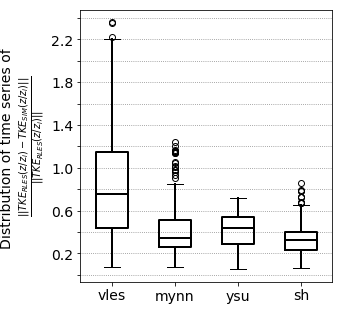

In [124]:
dflink = norms['tke_filt'].astype('float').copy()

fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111)

ax.grid(color='gray',linestyle=':',axis='y')
ax.set_yticks(np.arange(0,2.51,0.2))
for label in ax.get_yticklabels()[::2]:
    label.set_visible(False)

xticks = []
xticklabs = []

i=0
for sim in dflink.keys():
    print(sim)
    i+=1    
    
    ax.boxplot(dflink[sim].values, positions=[i],widths=[0.5],
              boxprops=allprops,
              medianprops=allprops,
              whiskerprops=allprops)    
    xticks.append(i)
    xticklabs.append(sim)
    
ax.set_xlim([0.5,4.5])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.set_ylabel('Distribution of time series of \n'+r"$\frac{|| TKE_{{RLES}}(z/z_i) - TKE_{{SIM}}(z/z_i)||}{|| TKE_{{RLES}}(z/z_i)||}$")

fig.subplots_adjust(left=0.4)
fig.savefig("/glade/u/home/doubrawa/figs/error_norms_filtered_tke.png",
           dpi=250,bbox_inches="tight")

vles
mynn
ysu
sh


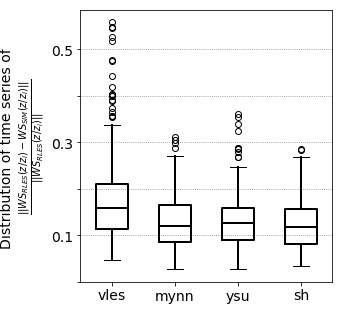

In [125]:
dflink = norms['ws_filt'].astype('float').copy()

fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111)

ax.grid(color='gray',linestyle=':',axis='y')
ax.set_yticks(np.arange(0,0.61,0.1))
for label in ax.get_yticklabels()[::2]:
    label.set_visible(False)

xticks = []
xticklabs = []

i=0
for sim in dflink.keys():
    print(sim)
    i+=1    
    
    ax.boxplot(dflink[sim].values, positions=[i],widths=[0.5],
              boxprops=allprops,
              medianprops=allprops,
              whiskerprops=allprops)    
    xticks.append(i)
    xticklabs.append(sim)
    
ax.set_xlim([0.5,4.5])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.set_ylabel('Distribution of time series of \n'+r"$\frac{|| WS_{{RLES}}(z/z_i) - WS_{{SIM}}(z/z_i)||}{|| WS_{{RLES}}(z/z_i)||}$")

fig.subplots_adjust(left=0.4)
fig.savefig("/glade/u/home/doubrawa/figs/error_norms_filtered_ws.png",
           dpi=250,bbox_inches="tight")

vles
mynn
ysu
sh


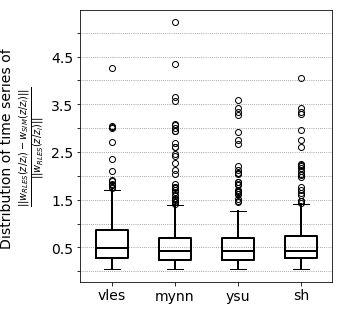

In [126]:
dflink = norms['w_filt'].astype('float').copy()

fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111)

ax.grid(color='gray',linestyle=':',axis='y')
ax.set_yticks(np.arange(0,5.51,0.5))
for label in ax.get_yticklabels()[::2]:
    label.set_visible(False)

xticks = []
xticklabs = []

i=0
for sim in dflink.keys():
    print(sim)
    i+=1    
    
    ax.boxplot(dflink[sim].values, positions=[i],widths=[0.5],
              boxprops=allprops,
              medianprops=allprops,
              whiskerprops=allprops)    
    xticks.append(i)
    xticklabs.append(sim)
    
ax.set_xlim([0.5,4.5])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.set_ylabel('Distribution of time series of \n'+r"$\frac{|| w_{{RLES}}(z/z_i) - w_{{SIM}}(z/z_i)||}{|| w_{{RLES}}(z/z_i)||}$")


fig.subplots_adjust(left=0.4)
fig.savefig("/glade/u/home/doubrawa/figs/error_norms_filtered_w.png",
           dpi=250,bbox_inches="tight")

vles
mynn
ysu
sh


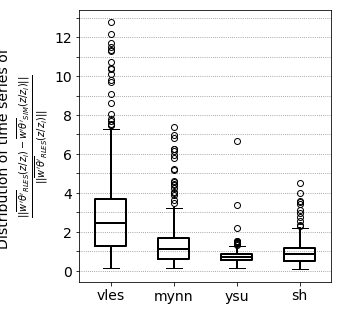

In [127]:
dflink = norms['wT_filt'].astype('float').copy()

fig = plt.figure(figsize=(7,5))
ax  = fig.add_subplot(111)

ax.grid(color='gray',linestyle=':',axis='y')
ax.set_yticks(np.arange(0,13.01,1))
for label in ax.get_yticklabels()[1::2]:
    label.set_visible(False)

xticks = []
xticklabs = []

i=0
for sim in dflink.keys():
    print(sim)
    i+=1    
    
    ax.boxplot(dflink[sim].values, positions=[i],widths=[0.5],
              boxprops=allprops,
              medianprops=allprops,
              whiskerprops=allprops)    
    xticks.append(i)
    xticklabs.append(sim)
    
ax.set_xlim([0.5,4.5])
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabs)
ax.set_ylabel('Distribution of time series of \n'+r"$\frac{|| \overline{{w'\theta'}}_{{RLES}}(z/z_i) - \overline{{w'\theta'}}_{{SIM}}(z/z_i)||}{|| \overline{{w'\theta'}}_{{RLES}}(z/z_i)||}$")

fig.subplots_adjust(left=0.4)
fig.savefig("/glade/u/home/doubrawa/figs/error_norms_filtered_wT.png",
           dpi=250,bbox_inches="tight")

In [19]:
len(profile_var)

34

In [ ]:
norms["tke_filt"]

In [50]:
diff = profile_ref - profile_var

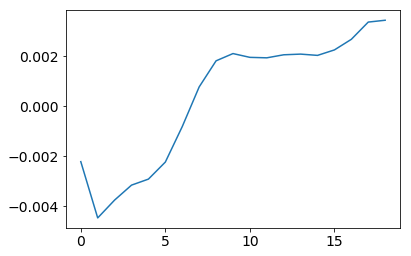

In [51]:
plt.plot(diff)

In [53]:
np.sqrt(np.sum(diff**2))

0.011236695520338786

0.3859295197031019

### compare profiles for filt vs. not filt

In [67]:
varname = "wT"

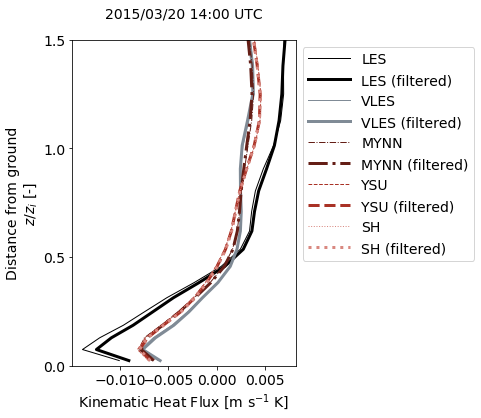

In [68]:
it = 0

time        = pd.Timestamp(all_data[sim]["time"].isel(time=it).data)
zi          = zi_dict[time.day]["median"].loc[time]

fig = plt.figure(figsize=(4,6))
ax  = fig.add_subplot(111)

for sim in sims:
    try:
        profile_var = all_data[sim][varname].isel(time=it).mean(dim=["south_north","west_east"])
        profile_var_filt = all_data[sim][varname+"_filt"].isel(time=it).mean(dim=["south_north","west_east"])        
    except:
        profile_var = all_data[sim][varname].isel(time=it)
        profile_var_filt = all_data[sim][varname+"_filt"].isel(time=it)
    
    profile_z   = all_data[sim]["z"].isel(time=it).mean(dim=["south_north","west_east"])
        
    profile_z  /= zi
    idx         = profile_z.data<=1.7
    
    profile_var = profile_var.data[idx]
    profile_var_filt = profile_var_filt.data[idx]
    profile_z   = profile_z.data[idx]
    
        
    ax.plot(profile_var, profile_z, color=colors[sim], ls=lss[sim], label=sim.upper(), lw=1)
    ax.plot(profile_var_filt, profile_z, color=colors[sim], ls=lss[sim], label=sim.upper()+" (filtered)", lw=3)    
    
ax.set_yticks([0,0.5,1,1.5])
ax.set_ylim([0,1.5])    
ax.set_ylabel("Distance from ground\n$z/z_i$ [-]")

# ax.set_xlim(xlims[varname])
ax.set_xlabel(labels[varname])

ax.set_title("{0:%Y/%m/%d %H:%M} UTC".format(time),fontsize=fs,y=1.05)

plt.legend(handlelength=3, bbox_to_anchor=(1,1))